In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

## They aim of this script is to 
## 1) evaluate information loss due to hourly aggregation
## 2) reconstruct information lost due to hourly aggregation

In [2]:
# we upload the time series with 5 minutes frequency. They data can be downloaded from figshare. https://doi.org/10.6084/m9.figshare.20080019 
df = pd.read_csv('/home/castaldm-admin/Downloads/videoStatististicsALL_from21_5minutes_anonymized.csv', sep=';')
df.head()

,Unnamed: 0,video_id,created_at,views
0,0,370133,2022-02-03 07:45:52.848943,24.0
1,1,370133,2022-02-03 07:50:52.670273,24.0
2,2,370133,2022-02-03 07:55:52.024137,24.0
3,3,370133,2022-02-03 08:00:52.701799,24.0
4,4,370133,2022-02-03 08:05:51.853291,25.0


In [3]:
#create a columns with views deltas
df['views_diff'] = df[['views', 'video_id']].groupby('video_id').views.diff()

#create a columns with corrections = negative views
df['corrections'] = [-el if el<0 else 0  for el in df.views_diff.values]

#we create a column "bool_corrections" equal to 1 if we have corrections in a certain hour, 0 if we don't/
df['bool_corrections'] = [1 if el>0 else 0  for el in df.corrections.values]

### From this higher granularity dataset we create an hourly dataset. From this hourly dataset we will try to reconstruct the corrections visible at 5-minutes frequency

In [4]:
#we create a column approximating the time with hour precision
df['created_at_approx'] = df['created_at'].apply(lambda x: x[:13])
df.head()

,Unnamed: 0,video_id,created_at,views,views_diff,corrections,bool_corrections,created_at_approx
0,0,370133,2022-02-03 07:45:52.848943,24.0,NaN,0.0,0,2022-02-03 07
1,1,370133,2022-02-03 07:50:52.670273,24.0,0.0,0.0,0,2022-02-03 07
2,2,370133,2022-02-03 07:55:52.024137,24.0,0.0,0.0,0,2022-02-03 07
3,3,370133,2022-02-03 08:00:52.701799,24.0,0.0,0.0,0,2022-02-03 08
4,4,370133,2022-02-03 08:05:51.853291,25.0,1.0,0.0,0,2022-02-03 08


In [5]:
df = df.sort_values(['video_id', 'created_at'])
df_agg = df[['video_id', 'created_at_approx', 'views']].groupby(['video_id', 'created_at_approx']).agg('last').reset_index()
df_agg.head()

,video_id,created_at_approx,views
0,370133,2022-02-03 07,24.0
1,370133,2022-02-03 08,27.0
2,370133,2022-02-03 09,29.0
3,370133,2022-02-03 10,32.0
4,370133,2022-02-03 11,37.0


In [6]:
#we want to remember the amount of corrections visible in the 5-minutes dataset and evaluate the corrections still visible in the hourly dataset.
df_agg2 = df[['video_id', 'created_at_approx', 'corrections']].groupby(['video_id', 'created_at_approx']).agg('sum').reset_index()
df_agg2 = df_agg2.rename(columns={'corrections':'corrections_raw'})
df_agg = pd.merge(df_agg.set_index(['video_id', 'created_at_approx']), df_agg2, on = ['video_id', 'created_at_approx'])
df_agg.head()

,video_id,created_at_approx,views,corrections_raw
0,370133,2022-02-03 07,24.0,0.0
1,370133,2022-02-03 08,27.0,0.0
2,370133,2022-02-03 09,29.0,0.0
3,370133,2022-02-03 10,32.0,0.0
4,370133,2022-02-03 11,37.0,0.0


In [7]:
df_agg = df_agg.rename(columns={'created_at_approx':'created_at'})
df_agg = df_agg.rename(columns={'views':'views_hourly'})

In [78]:
# create column views_diff
df_agg2 = pd.DataFrame({'video_id':df_agg.video_id.unique(), 'created_at' :pd.to_datetime(1490195805, unit='s'), 'views_hourly': 0})
df_agg = pd.concat([df_agg, df_agg2])
#sort by video and created at
df_agg = df_agg.sort_values(by=['video_id', 'created_at']).reset_index()
df_agg['views_diff_hourly'] = df_agg.views_hourly.diff()
df_agg.head()

df_agg = df_agg[df_agg.created_at != pd.to_datetime(1490195805, unit='s')]
df_agg.head()

,level_0,index,video_id,created_at,views_hourly,corrections_raw,views_diff_hourly,corrections_hourly,bool_corrections_hourly,bool_corrections_raw,hour,hour_from_beginning
1,1,0.0,370133,2022-02-03 07,24.0,0.0,24.0,0.0,0.0,0.0,7.0,0.0
2,2,1.0,370133,2022-02-03 08,27.0,0.0,3.0,0.0,0.0,0.0,8.0,1.0
3,3,2.0,370133,2022-02-03 09,29.0,0.0,2.0,0.0,0.0,0.0,9.0,2.0
4,4,3.0,370133,2022-02-03 10,32.0,0.0,3.0,0.0,0.0,0.0,10.0,3.0
5,5,4.0,370133,2022-02-03 11,37.0,0.0,5.0,0.0,0.0,0.0,11.0,4.0


In [79]:
#evaluate total corrections to see the information loss
df_agg['corrections_hourly'] = 0
df_agg.loc[df_agg.views_diff_hourly < 0, 'corrections_hourly'] = -df_agg[df_agg.views_diff_hourly < 0].views_diff_hourly.values
df_agg['bool_corrections_hourly'] = [1 if el>0 else 0  for el in df_agg.corrections_hourly.values]
df_agg['bool_corrections_raw'] = 0

df_agg.loc[df_agg.corrections_raw> 0, 'bool_corrections_raw'] = 1
df_agg.head()

,level_0,index,video_id,created_at,views_hourly,corrections_raw,views_diff_hourly,corrections_hourly,bool_corrections_hourly,bool_corrections_raw,hour,hour_from_beginning
1,1,0.0,370133,2022-02-03 07,24.0,0.0,24.0,0,0,0,7.0,0.0
2,2,1.0,370133,2022-02-03 08,27.0,0.0,3.0,0,0,0,8.0,1.0
3,3,2.0,370133,2022-02-03 09,29.0,0.0,2.0,0,0,0,9.0,2.0
4,4,3.0,370133,2022-02-03 10,32.0,0.0,3.0,0,0,0,10.0,3.0
5,5,4.0,370133,2022-02-03 11,37.0,0.0,5.0,0,0,0,11.0,4.0


In [80]:
# Now we can study the information loss due to hourly aggegation and try to reconstruct it though our benchmarck model
# To apply the benchmark method it's easier to change the format of the timeseries and save them as a list in a columns of the dataset for every video.

df_agg_errors = df_agg.groupby(['video_id']).agg({'views_diff_hourly':list,
                         'corrections_raw':list,
                         'corrections_hourly':list,
                         'created_at':'min',
                         'bool_corrections_raw':list,
                         'bool_corrections_hourly':list,
                         }).reset_index()
# free some space in memory

df_agg_errors['tot_views_hourly'] = df_agg_errors['views_diff_hourly'].apply(lambda x : np.sum(x))
df_agg_errors['tot_bot_hourly'] = df_agg_errors['corrections_hourly'].apply(lambda x : np.sum(x))
df_agg_errors['tot_bot_raw'] = df_agg_errors['corrections_raw'].apply(lambda x: np.sum(x))
df_agg_errors['tot_interventions_raw'] = df_agg_errors['bool_corrections_raw'].apply(lambda x: np.sum(x))
df_agg_errors.head()

,video_id,views_diff_hourly,corrections_raw,corrections_hourly,created_at,bool_corrections_raw,bool_corrections_hourly,tot_views_hourly,tot_bot_hourly,tot_bot_raw,tot_interventions_raw
0,370133,"[24.0, 3.0, 2.0, 3.0, 5.0, 3.0, 2.0, 0.0, 2.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-02-03 07,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",137.0,0,0.0,0
1,370134,"[9.0, 5.0, 2.0, 5.0, 2.0, 2.0, 1.0, 3.0, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-02-06 03,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48.0,0,0.0,0
2,370135,"[707.0, 876.0, 778.0, 797.0, 771.0, 631.0, 747...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-02-06 22,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",15094.0,0,11.0,3
3,370136,"[5.0, 7.0, 8.0, 4.0, 1.0, 3.0, 3.0, 3.0, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-02-03 16,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",129.0,0,0.0,0
4,370137,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-02-04 10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11762.0,30,73.0,5


We can introduce the error measures

In [81]:
#We define our error metrics

def lost_interventions(x):

    raw = np.array(x[0])
    reconstructed = np.array(x[1])
    return len(raw[(raw > 0) & (reconstructed == 0)])


def added_interventions(x):

    raw = np.array(x[0])
    reconstructed = np.array(x[1])
    return len(raw[(raw == 0) & (reconstructed > 0)])


def lost_corrections(x):

    raw = np.array(x[0])
    other = np.array(x[1])
    idx = np.linspace(0, len(raw)-1, len(raw))
    idx = idx[raw > other]
    idx = [int(i) for i in idx]
    return np.sum(raw[idx]-other[idx])


def added_corrections(x):

    raw = np.array(x[0])
    other = np.array(x[1])
    idx = np.linspace(0, len(raw)-1, len(raw))
    idx = idx[raw < other]
    idx = [int(i) for i in idx] 
    return np.sum(raw[idx]-other[idx])

In [82]:
df_agg_errors['lost_corrections_hourly'] = df_agg_errors[['corrections_raw', 'corrections_hourly']].apply(lost_corrections, axis = 1)
print('The lost corrections with the hourly aggregation are '+ str(df_agg_errors.lost_corrections_hourly.sum()/df_agg_errors['tot_bot_raw'].sum()))

df_agg_errors['added_corrections_hourly'] = df_agg_errors[['corrections_raw', 'corrections_hourly']].apply(added_corrections, axis = 1)
print('The added corrections with the hourly aggregation are ' + str(df_agg_errors.added_corrections_hourly.sum()/df_agg_errors['tot_bot_raw'].sum()))

df_agg_errors['lost_interventions_hourly'] = df_agg_errors[['corrections_raw', 'corrections_hourly']].apply(lost_interventions, axis = 1)
print('The lost interventions with the hourly aggregation are ' + str(df_agg_errors.lost_interventions_hourly.sum()/df_agg_errors['tot_interventions_raw'].sum()))

df_agg_errors['added_interventions_hourly'] = df_agg_errors[['corrections_raw', 'corrections_hourly']].apply(added_interventions, axis = 1)
print('The added interventions with the hourly aggregation are ' + str(df_agg_errors.added_interventions_hourly.sum()/df_agg_errors['tot_interventions_raw'].sum()))

The lost corrections with the hourly aggregation are 0.6631743392765006
The added corrections with the hourly aggregation are 0.0
The lost interventions with the hourly aggregation are 0.6
The added interventions with the hourly aggregation are 0.0


Let's try to reconstruct the real loss in terms of negative views though an euristic

In [83]:
# dove viene predetta una correzione dobbiamo stimare a quanto ammonta, possiamo utilizzare il metodo A

h = 1
  
def benchmarkModel(x):
    
    corr = np.array(x[0])
    views = x[1].copy()

    if sum(corr)> 0 :

        for i in range(1, len(views)-1):
            if corr[i] > 0:
                start = np.max([i-h, 0])
                end = np.min([len(views), i+h+1])
                
                expected = np.min([*views[start:i], *views[i+1:end]])                     
                
                if expected < 0:
                    expected = 0
                if expected > np.sum(views[:i]):
                    expected = np.sum(views[:i])
                corr[i] = corr[i] + expected
                views[i] = -corr[i]
    return corr  

df_agg_errors['estimated_corrections_methodA'] = df_agg_errors[['corrections_hourly', 'views_diff_hourly']].apply(benchmarkModel, axis=1)


df_agg_errors['lost_corrections_benchmarkMethod'] = df_agg_errors[['corrections_raw', 'estimated_corrections_methodA']].apply(lost_corrections, axis = 1)
print('The lost corrections with the hourly aggregation are '+ str(df_agg_errors.lost_corrections_benchmarkMethod.sum()/df_agg_errors['tot_bot_raw'].sum()))

df_agg_errors['added_corrections_benchmarkMethod'] = df_agg_errors[['corrections_raw', 'estimated_corrections_methodA']].apply(added_corrections, axis = 1)
print('The added corrections with the hourly aggregation are ' + str(df_agg_errors.added_corrections_benchmarkMethod.sum()/df_agg_errors['tot_bot_raw'].sum()))

df_agg_errors['lost_interventions_benchmarkMethod'] = df_agg_errors[['corrections_raw', 'estimated_corrections_methodA']].apply(lost_interventions, axis = 1)
print('The lost interventions with the hourly aggregation are ' + str(df_agg_errors.lost_interventions_benchmarkMethod.sum()/df_agg_errors['tot_interventions_raw'].sum()))

df_agg_errors['added_interventions_benchmarkMethod'] = df_agg_errors[['corrections_raw', 'estimated_corrections_methodA']].apply(added_interventions, axis = 1)
print('The added interventions with the hourly aggregation are ' + str(df_agg_errors.added_interventions_benchmarkMethod.sum()/df_agg_errors['tot_interventions_raw'].sum()))


The lost corrections with the hourly aggregation are 0.5027518202144127
The added corrections with the hourly aggregation are -0.01626727053832483
The lost interventions with the hourly aggregation are 0.6
The added interventions with the hourly aggregation are 0.0


## Now that we know these methods are not sufficients we can turn to training our classifier

In [84]:
# some few more information to extract that could be usefull for our classifier
df_agg['hour'] = pd.to_datetime(df_agg['created_at']).dt.hour
df_agg['hour_from_beginning'] = df_agg.groupby(['video_id', 'created_at']).ngroup()
df_agg.head()

,level_0,index,video_id,created_at,views_hourly,corrections_raw,views_diff_hourly,corrections_hourly,bool_corrections_hourly,bool_corrections_raw,hour,hour_from_beginning
1,1,0.0,370133,2022-02-03 07,24.0,0.0,24.0,0,0,0,7,0
2,2,1.0,370133,2022-02-03 08,27.0,0.0,3.0,0,0,0,8,1
3,3,2.0,370133,2022-02-03 09,29.0,0.0,2.0,0,0,0,9,2
4,4,3.0,370133,2022-02-03 10,32.0,0.0,3.0,0,0,0,10,3
5,5,4.0,370133,2022-02-03 11,37.0,0.0,5.0,0,0,0,11,4


We now want to build a classifier able to recognize the hours that had some corrections which are not visible anymore with the hourly aggregation of our data. \n Hence we need to train the classifier only on hours with "bool_corrections_raw" = 1 and "bool_corrections_hourly" = 0

In [85]:
# we create a list of channels WITH hidden corrections and we are going to train the classifier over those data
hidden_videos = df_agg[df_agg.bool_corrections_raw >  df_agg.bool_corrections_hourly ].video_id.unique()
df_agg_hidden = df_agg[df_agg.video_id.isin(hidden_videos)]
df_agg_hidden.head()

,level_0,index,video_id,created_at,views_hourly,corrections_raw,views_diff_hourly,corrections_hourly,bool_corrections_hourly,bool_corrections_raw,hour,hour_from_beginning
341,341,338.0,370135,2022-02-06 22,707.0,0.0,707.0,0,0,0,22,338
342,342,339.0,370135,2022-02-06 23,1583.0,0.0,876.0,0,0,0,23,339
343,343,340.0,370135,2022-02-07 00,2361.0,0.0,778.0,0,0,0,0,340
344,344,341.0,370135,2022-02-07 01,3158.0,0.0,797.0,0,0,0,1,341
345,345,342.0,370135,2022-02-07 02,3929.0,0.0,771.0,0,0,0,2,342


We are now ready to create the dataset for the classifier. We first built it and then devide it in train and test set.
We basically create a matrix X that has for rows the hours with hidden corrections and as columns tha historical evokution of the timeserie before and after the hour concerned. To the historical evolution we add, as features, the hour of the day and the number of hours passed since pubblication

In [91]:
#create the empty matrix X
X = np.zeros([len(df_agg_hidden), 50])

for i in range(0, 48):

    temp = df_agg_hidden[['views_diff_hourly', 'video_id']].groupby('video_id')['views_diff_hourly'].shift(i-24)
    temp[temp != temp] = 0
    X[:,i] = temp

#Add a columns with the hour of the day
X[:, 48] = df_agg_hidden.hour

# add the hour since publication
X[:,49] = df_agg_hidden.hour_from_beginning

In [92]:
#Let's have a look at X
X

array([[1.26000e+02, 2.21000e+02, 2.95000e+02, ..., 0.00000e+00,
        2.20000e+01, 3.38000e+02],
       [9.80000e+01, 1.26000e+02, 2.21000e+02, ..., 0.00000e+00,
        2.30000e+01, 3.39000e+02],
       [1.93000e+02, 9.80000e+01, 1.26000e+02, ..., 0.00000e+00,
        0.00000e+00, 3.40000e+02],
       ...,
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        1.60000e+01, 1.71022e+05],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        1.70000e+01, 1.71023e+05],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        1.80000e+01, 1.71024e+05]])

In [94]:
import numpy as np
from sklearn.model_selection import GridSearchCV

#we devide train and test set in order not to have the same video in both.

y_train = df_agg_hidden['bool_corrections_raw'][:90075]
y_test = df_agg_hidden['bool_corrections_raw'][90075:]

X_train = X[:90075]
X_test = X[90075:]


In [95]:
X_train

array([[1.26000e+02, 2.21000e+02, 2.95000e+02, ..., 0.00000e+00,
        2.20000e+01, 3.38000e+02],
       [9.80000e+01, 1.26000e+02, 2.21000e+02, ..., 0.00000e+00,
        2.30000e+01, 3.39000e+02],
       [1.93000e+02, 9.80000e+01, 1.26000e+02, ..., 0.00000e+00,
        0.00000e+00, 3.40000e+02],
       ...,
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        1.10000e+01, 1.35195e+05],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        1.20000e+01, 1.35196e+05],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 1.00000e+00,
        1.30000e+01, 1.35197e+05]])

In [96]:
y_train

341       0
342       0
343       0
344       0
345       0
         ..
135993    0
135994    0
135995    0
135996    0
135997    0
Name: bool_corrections_raw, Length: 90075, dtype: int64

## actual training of the classifier

In [97]:
import os
import numpy as np
import itertools
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer, f1_score

max_depths = [ 25, 30, 35]
learning_rates = [0.2, 0.25, 0.3, 0.35]
alpha = [1, 2, 3, 4, 5, 6]

# load data in do training
performances = pd.DataFrame(columns = {'max_depth', 'learning_rates', 'alpha', 'auc'})


for a, b, c in itertools.product(max_depths, learning_rates, alpha):
    
    model = XGBClassifier(max_depth=a, learning_rate= b, alpha= c, seed = 1)

    print('running cross validation')
    # do cross validation, this will print result out as
    # [iteration]  metric_name:mean_value+std_value
    # std_value is standard deviation of the metric
    kfold = model_selection.KFold(n_splits=5)
    #model=RandomForestClassifier(n_estimators=50) 

    results = model_selection.cross_val_score(estimator=model,
                                            X=X_train,
                                            y=y_train,
                                            cv=kfold,
                                            scoring=make_scorer(f1_score))

    score = results.mean()
    print(str(a) + ' ' + str(b) + ' '+ str(c)+ ' '+ str(score))
    performances = pd.concat([performances, pd.DataFrame({'max_depth':[a], 'learning_rates':[b], 'alpha':[c], 'f1':[score]})])


running cross validation
25 0.2 1 0.6486358277901199
running cross validation
25 0.2 2 0.6421270490891848
running cross validation
25 0.2 3 0.639405409305704
running cross validation
25 0.2 4 0.6414199705223893
running cross validation
25 0.2 5 0.6411489639028247
running cross validation
25 0.2 6 0.6435799951910333
running cross validation
25 0.25 1 0.6423688154183624
running cross validation
25 0.25 2 0.6479733302343839
running cross validation
25 0.25 3 0.6468261732405598
running cross validation
25 0.25 4 0.6437959390731801
running cross validation
25 0.25 5 0.6381984509083098
running cross validation
25 0.25 6 0.6442051960761732
running cross validation
25 0.3 1 0.6428329012933957
running cross validation
25 0.3 2 0.6422124808333904
running cross validation
25 0.3 3 0.6442531476644042
running cross validation
25 0.3 4 0.6380571218764917
running cross validation
25 0.3 5 0.6405981701580643
running cross validation
25 0.3 6 0.6361991982123528
running cross validation
25 0.35 1 0.6402

In [98]:
performances

,max_depth,alpha,auc,learning_rates,f1
0,25,1,NaN,0.2,0.648636
0,25,2,NaN,0.2,0.642127
0,25,3,NaN,0.2,0.639405
0,25,4,NaN,0.2,0.641420
0,25,5,NaN,0.2,0.641149
...,...,...,...,...,...
0,35,2,NaN,0.35,0.641839
0,35,3,NaN,0.35,0.646301
0,35,4,NaN,0.35,0.641338
0,35,5,NaN,0.35,0.642976


Text(33.0, 0.5, 'Alpha')

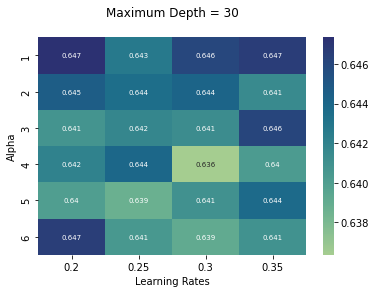

In [99]:
table = pd.pivot_table(performances[performances.max_depth == 30], values='f1', index=['alpha'],columns=['learning_rates'], aggfunc=np.sum)
fig = plt.figure(facecolor= 'white')
sns.heatmap(table, annot=True, annot_kws={"size": 7}, cmap = 'crest', fmt=".3")
plt.title('Maximum Depth = 30\n')
plt.xlabel('Learning Rates')
plt.ylabel('Alpha')
#plt.savefig('maxdepth30.pdf')

Text(33.0, 0.5, 'Alpha')

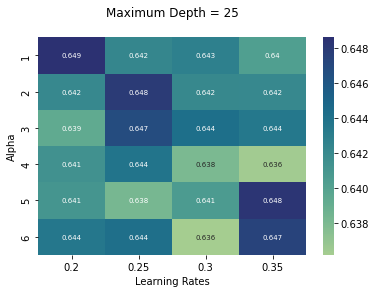

In [100]:
table = pd.pivot_table(performances[performances.max_depth == 25], values='f1', index=['alpha'],columns=['learning_rates'], aggfunc=np.sum)
fig = plt.figure(facecolor= 'white')
sns.heatmap(table, annot=True, annot_kws={"size": 7}, cmap = 'crest', fmt=".3")
plt.title('Maximum Depth = 25\n')
plt.xlabel('Learning Rates')
plt.ylabel('Alpha')
#plt.savefig('maxdepth25.pdf')

## The best parameters, able to grant an F1 score equal to 0.649, are a maximum depth equal to 25, a learning rate equal to 0.2 and alpha equal to 1

In [107]:
import xgboost as xgb
from sklearn.metrics import f1_score
#chosen parameters

max_depth = 25
learning_rate = 0.2
alpha = 1
param = {'max_depth':max_depth, 'learning_rate': learning_rate, 'alpha': alpha, 'objective':'binary:logistic'}
dtrain = xgb.DMatrix(data = X, label = [*y_train, *y_test])

bst = xgb.train(param, dtrain)


# We save the model

In [108]:
# save the model to JSON file
bst.save_model("reconstruction_model.json")

In [109]:
# to upload the model used in the paper
import xgboost as xgb

model_xgb_2 = xgb.Booster()
model_xgb_2.load_model("reconstruction_model.json")